In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/New_120dog breeds-224.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/projectDataset224')

In [ ]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization

In [ ]:
import pathlib
from keras.preprocessing.image import ImageDataGenerator


data_dir = pathlib.Path('/content/projectDataset224/New_120dog breeds-224')

data_train = data_dir / 'train'

test_dir = data_dir / 'test'


# labels_csv = pd.read_csv('/content/drive/MyDrive/labels.csv')
# labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]
labels_csv = pd.read_csv('/content/drive/MyDrive/labelsNew.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]

In [ ]:
batch_size = 16
img_size = 224

In [ ]:
# datagen = ImageDataGenerator(preprocessing_function = keras.applications.resnet50.preprocess_input, validation_split=0.2)
# train_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='training',
#                         x_col='id',
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))

# validation_generator = datagen.flow_from_dataframe(
#                         dataframe = labels_csv,
#                         directory = data_train,
#                         subset='validation',
#                         x_col='id', 
#                         y_col='breed',
#                         batch_size=batch_size,
#                         shuffle=True,
#                         class_mode='sparse',
#                         color_mode='rgb',
#                         target_size=(img_size, img_size))


train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='training',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    # class_mode='sparse',
    class_mode='categorical',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

validation_datagen = ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input, 
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=labels_csv,
    directory=data_train,
    subset='validation',
    x_col='id',
    y_col='breed',
    batch_size=batch_size,
    shuffle=True,
    # class_mode='sparse',
    class_mode='categorical',
    color_mode='rgb',
    target_size=(img_size, img_size)
)


from keras.utils import to_categorical
train_labels = to_categorical(train_generator.labels)
validation_labels = to_categorical(validation_generator.labels)

Found 7218 validated image filenames belonging to 120 classes.
Found 1804 validated image filenames belonging to 120 classes.


In [ ]:
import tensorflow as tf
from tensorflow.python.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc

# Define the ROC metrics
tpr = tf.keras.metrics.TruePositives(name='tp')
fpr = tf.keras.metrics.FalsePositives(name='fp')
auc_metric = AUC(name='auc')

In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))

for layer in resnet50.layers:
    layer.trainable=False

model = Sequential()
model.add(resnet50)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))
model.summary()

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer,
              # loss='sparse_categorical_crossentropy',
              loss='categorical_crossentropy',
              metrics=[tpr, fpr, auc_metric, 'accuracy', 'Precision', 'Recall'])
              # metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                         

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
# history_res = model.fit(train_generator, epochs=50, verbose = 1,
#                        validation_data=validation_generator)

from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint_cb = ModelCheckpoint("/content/drive/MyDrive/Resnet50-Epoch50Version6_New120breeds.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history_res = model.fit(train_generator, epochs=50, verbose = 1,
                        validation_data=validation_generator,
                        callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
452/452 [==============================] - 162s 329ms/step - loss: 3.8199 - tp: 18.0000 - fp: 0.0000e+00 - auc: 0.6948 - accuracy: 0.2146 - precision: 1.0000 - recall: 0.0025 - val_loss: 2.2622 - val_tp: 88.0000 - val_fp: 1.0000 - val_auc: 0.8467 - val_accuracy: 0.6214 - val_precision: 0.9888 - val_recall: 0.0488
Epoch 2/50
452/452 [==============================] - 150s 331ms/step - loss: 2.1197 - tp: 832.0000 - fp: 79.0000 - auc: 0.8971 - accuracy: 0.5396 - precision: 0.9133 - recall: 0.1153 - val_loss: 1.2825 - val_tp: 667.0000 - val_fp: 60.0000 - val_auc: 0.9263 - val_accuracy: 0.7007 - val_precision: 0.9175 - val_recall: 0.3697
Epoch 3/50
452/452 [==============================] - 128s 283ms/step - loss: 1.4459 - tp: 2391.0000 - fp: 236.0000 - auc: 0.9421 - accuracy: 0.6480 - precision: 0.9102 - recall: 0.3313 - val_loss: 0.9846 - val_tp: 945.0000 - val_fp: 115.0000 - val_auc: 0.9529 - val_accuracy: 0.7345 - val_precision: 0.8915 - val_recall: 0.5238
Epoch 4/50
452/452 

In [ ]:
model.save('/content/drive/MyDrive/Resnet50-Epoch50_Version6_New120breeds.h5')

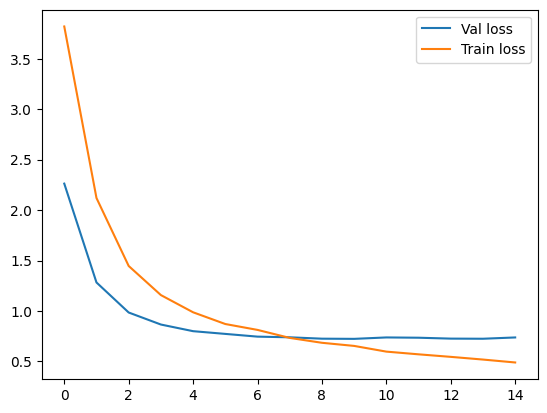

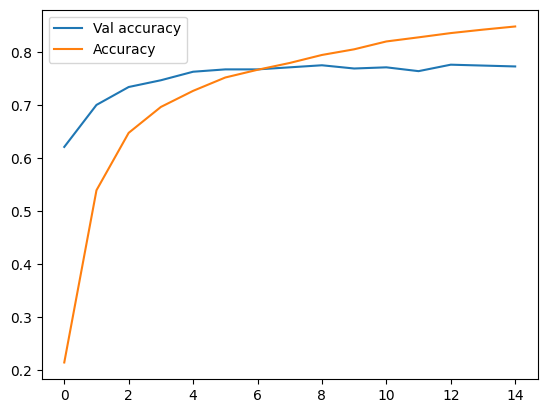

In [ ]:
plt.figure()
plt.plot(history_res .history['val_loss'], label = 'Val loss')
plt.plot(history_res .history['loss'], label = 'Train loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(history_res .history['val_accuracy'], label = 'Val accuracy')
plt.plot(history_res .history['accuracy'], label = 'Accuracy')
plt.legend()
plt.show()

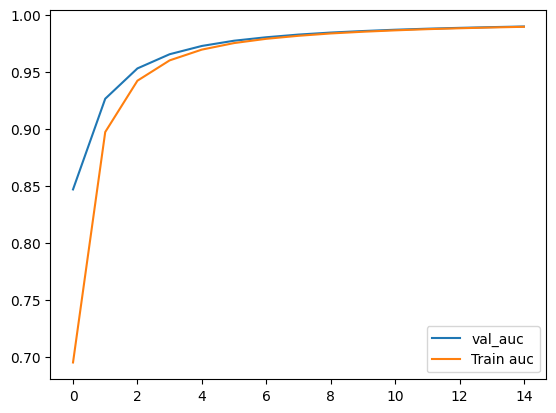

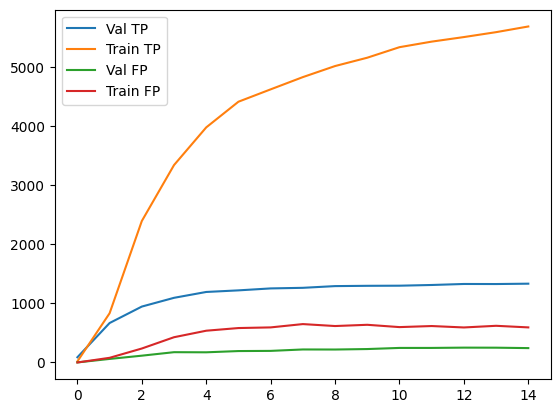

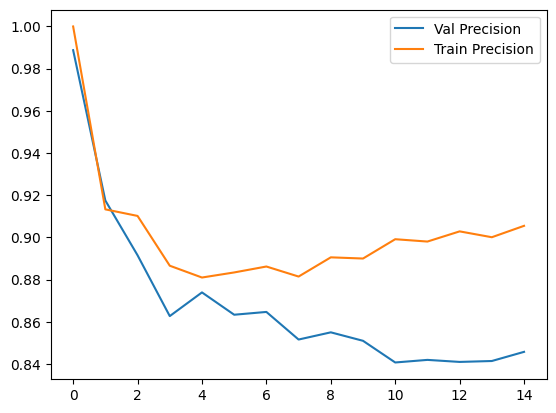

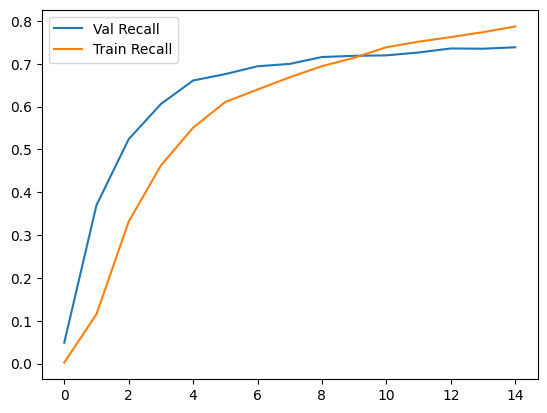

In [ ]:
plt.figure()
plt.plot(history_res .history['val_auc'], label = 'val_auc')
plt.plot(history_res .history['auc'], label = 'Train auc')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_res .history['val_tp'], label = 'Val TP')
plt.plot(history_res .history['tp'], label = 'Train TP')
plt.plot(history_res .history['val_fp'], label = 'Val FP')
plt.plot(history_res .history['fp'], label = 'Train FP')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_res .history['val_precision'], label = 'Val Precision')
plt.plot(history_res .history['precision'], label = 'Train Precision')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_res .history['val_recall'], label = 'Val Recall')
plt.plot(history_res .history['recall'], label = 'Train Recall')
plt.legend()
plt.show()



In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Resnet50-Epoch50_Version6_New120breeds.h5')

In [ ]:
testing_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
)
testing_generator = testing_datagen.flow_from_directory(
    directory=test_dir,
    shuffle=False,
    class_mode='categorical',
    color_mode='rgb',
    target_size=(img_size, img_size)
)

from keras.utils import to_categorical
testing_labels = to_categorical(testing_generator.labels)

Found 1200 images belonging to 120 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

import itertools



y_pred = model.predict(testing_generator)

38/38 [==============================] - 249s 6s/step


In [ ]:
from keras.utils import to_categorical

y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
y_true = testing_generator.labels
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
print("y_true shape:", y_true.shape)
print("y_pred_classes shape:", y_pred_classes.shape)


y_true shape: (1200,)
y_pred_classes shape: (1200,)


In [ ]:
print(y_true)
print(y_pred_classes)

[  0   0   0 ... 119 119 119]
[  0   0  48 ...  99 119  27]


In [ ]:
import numpy as np
count = np.count_nonzero(y_true != y_pred_classes)
print(count)

288


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_true, y_pred_classes)
f1_score = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print('Testing accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)


Testing accuracy: 0.76
F1 score: 0.7578130572022415
Recall: 0.76
Precision: 0.7753088421654598


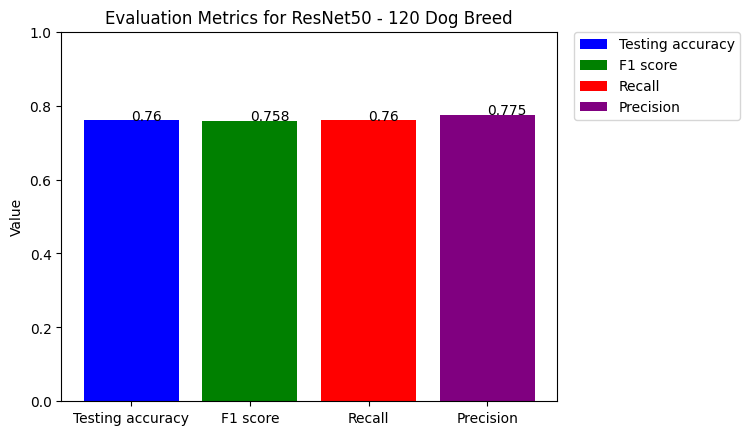

In [ ]:
# TestingACC recall, f1-score, presicion
import matplotlib.pyplot as plt

# accuracy = 0.93
# f1_score = 0.9286108132178744
# recall = 0.93
# precision = 0.9368409368409369

plt.bar(['Testing accuracy', 'F1 score', 'Recall', 'Precision'], 
        [accuracy, f1_score, recall, precision], 
        color=['blue', 'green', 'red', 'purple'],
        label=['Testing accuracy', 'F1 score', 'Recall', 'Precision'])

plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.88))

for index, value in enumerate([accuracy, f1_score, recall, precision]):
    plt.text(index, value + 0.001, str(round(value, 3)))

plt.title('Evaluation Metrics for ResNet50 - 120 Dog Breed')
plt.ylabel('Value')

plt.ylim([0, 1.05])

plt.show()

Text(0.5, 1.0, 'Confusion Matrix - 120 Dog Breeds In ResNet50 Model')

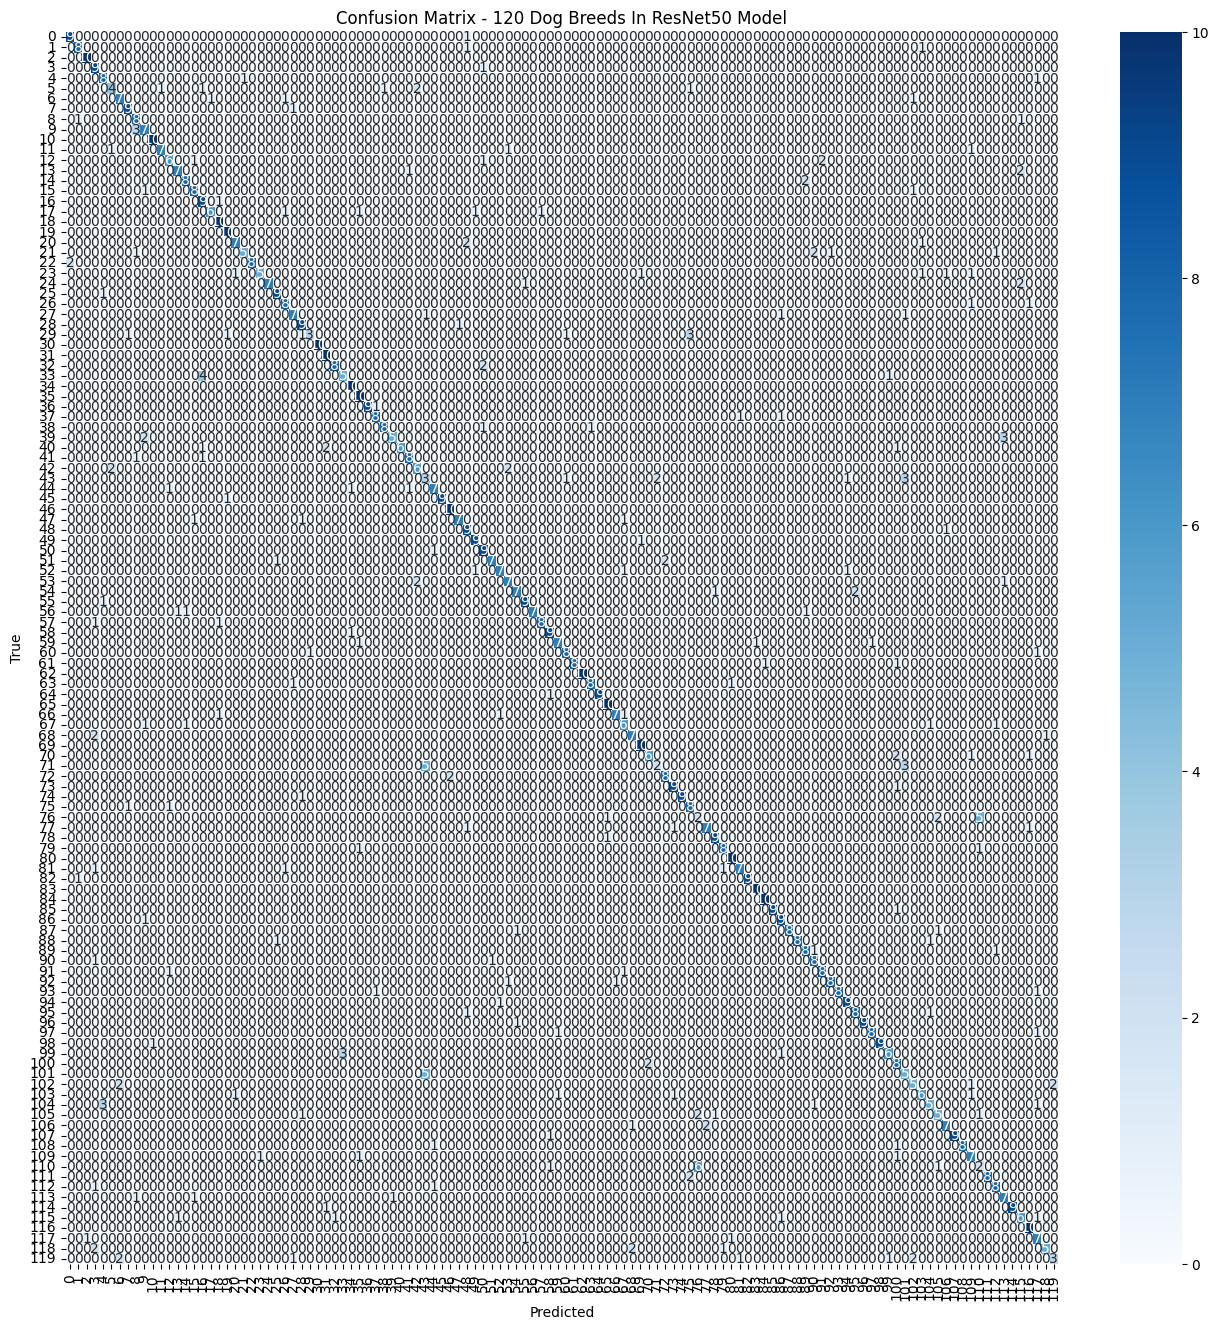

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


confusion_matrix = confusion_matrix(y_true, y_pred_classes)


class_names = [str(i) for i in range(120)]


plt.figure(figsize=(16, 16))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix - 120 Dog Breeds In ResNet50 Model")

In [ ]:

y_true = to_categorical(testing_generator.labels)
y_pred_classes = to_categorical(y_pred_classes)

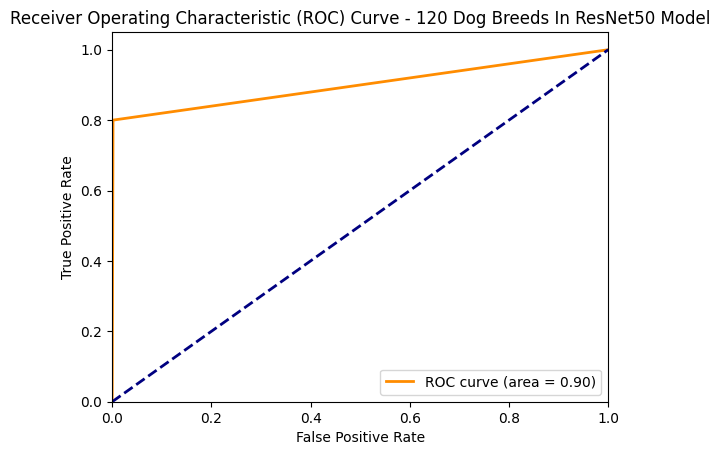

In [ ]:

# fpr, tpr, thresholds = roc_curve(y_true[:, 1], y_pred_classes)
fpr, tpr, thresholds = roc_curve(y_true[:, 1], y_pred_classes[:, 1])

roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 120 Dog Breeds In ResNet50 Model')
plt.legend(loc="lower right")
plt.show()